<a href="https://colab.research.google.com/github/XingruiWang/RUC-Deep-Learning-Course/blob/master/Homework/HW_7/hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 广告效果预测

### 背景介绍

**搜索引擎营销**（SEM: Search Engine Marketing）的核心是通过搜索引擎上，用户主动输入表达的意愿，推送相应的广告信息。搜索引擎营销运营的关键环节之一就是**关键词拓展**。所谓关键词拓展，就是根据已有的关键词表现数据，推测还有哪些尚未购买的关键词。因此，你需要构造一个从**X = 关键词**到**Y = 广告效果**的回归模型。不同场景下对广告效果的定义个不相同。可能是展现、点击、转化、再购买等。这样就构成了一个完整的销售漏斗。而本案例关注该销售漏斗的第一个环节：展现。具体而言，**因变量是Y=log(展现量)**，直接反映了广告主信息在用户面前暴露的强度。而X就是关键词本身的文本信息。

### 方法介绍

#### 一、分词

源数据中x为用户搜索内容，为了更好提取内容的语义信息，我们先将内容分割成不同的汉语词语。分词的工具采用的是python中的Jiba包。

#### 二、word to vector

在分词之后，我使用word-to-vector词编码模型对文本数据进行量化

#### 三、RNN模型

<img src = 'https://camo.githubusercontent.com/bee147253f0a81a87f02200007716adaf97943f6/687474703a2f2f6b657875652e666d2f7573722f75706c6f6164732f323031352f30382f323036373734313235372e706e67' width=70%>


In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


### 模型搭建

一、数据读入与初步分词

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.954 seconds.
Prefix dict has been built successfully.


-------------- y的分布 -----------------


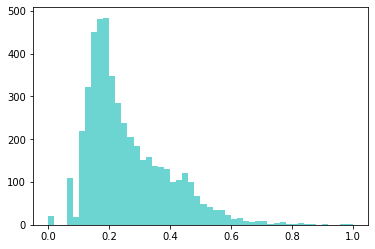


-------------- 分词结果 -----------------
吉林机票 	 ['吉林', '机票']
济南特价飞机票查询 	 ['济南', '特价', '飞机票', '查询']
三亚机票价格 	 ['三亚', '机票价格']
井冈山机票 	 ['井冈山', '机票']
上海到石家庄特价机票 	 ['上海', '到', '石家庄', '特价机票']
广州机票哪个网站便宜 	 ['广州', '机票', '哪个', '网站', '便宜']
贵阳特价机票 	 ['贵阳', '特价机票']
南京飞机票-预订 	 ['南京', '飞机票', '-', '预订']
黄山自由行攻略 	 ['黄山', '自由', '行', '攻略']
郑州航班查询 	 ['郑州', '航班', '查询']

-------------- 词频前20统计 -----------------
506 words in total
[('机票', 1954), ('飞机票', 971), ('特价机票', 633), ('查询', 625), ('预订', 449), ('便宜', 392), ('-', 369), ('打折', 327), ('特价', 268), ('到', 267), ('深圳', 265), ('北京', 256), ('航班', 243), ('广州', 240), ('的', 235), ('上海', 223), ('预定', 215), ('网站', 215), ('网', 180), ('飞机', 170)]


In [2]:
# drive/MyDrive/RUC/DeepLearning/course7/SEM.csv
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import jieba
import random
from collections import Counter
%matplotlib inline


data_table = pd.read_csv('drive/MyDrive/RUC/DeepLearning/course7/SEM.csv')
sentences, y = data_table["kw"], data_table["logImp"].to_numpy().astype(np.float32)
N = len(y)

# 数据预处理
y = (y - y.min()) / (y.max() - y.min())
train_data = []
for s in sentences:
  train_data.append(jieba.lcut(s))

# train_data = np.array(train_data)

print("-------------- y的分布 -----------------")
plt.hist(y, bins=50, color = "#0ABAB5", alpha = 0.6)
plt.show()


print("\n-------------- 分词结果 -----------------")
show_index = random.sample(range(N), 10)
for s, cut in zip(sentences[show_index], np.array(train_data)[show_index]):
  print(s, "\t", cut)


print("\n-------------- 词频前20统计 -----------------")

all_words = np.hstack(train_data)
words_count = Counter(all_words)
W = len(words_count)
print("%d words in total"%(W))
print(words_count.most_common(20))


#### 二、Word to vector

In [3]:
# 训练词向量
from gensim.models import Word2Vec
vec_size = 100

w2v = Word2Vec(train_data, size = vec_size, min_count=1)
w2v.wv['机票'].shape

(100,)

In [4]:
# 词编码
from tensorflow.python.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters = "", split = " ")
tokenizer.fit_on_texts(train_data)

train_tokens = tokenizer.texts_to_sequences(train_data)

max_len = max([len(t) for t in train_tokens])
print(max_len)
print("----------Tokenizer 结果-----------------")
for d, t in zip(train_data[:10], train_tokens[:10]):
  print(d, t)

7
----------Tokenizer 结果-----------------
['1.5', '折', '机票'] [363, 123, 1]
['10.1', '机票'] [240, 1]
['10.1', '机票', '查询'] [240, 1, 4]
['10.1', '特价机票'] [240, 3]
['10', '月份', '特价机票'] [364, 146, 3]
['17u', '.', 'cn'] [365, 366, 367]
['1', '元', '机票'] [134, 368, 1]
['1', '折', '机票', '查询'] [134, 123, 1, 4]
['1', '折', '机票', '订购'] [134, 123, 1, 34]
['1', '折', '机票网'] [134, 123, 59]


In [5]:
# 序列补全
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

train_pad = pad_sequences(train_tokens, maxlen=max_len,
                            padding='pre', truncating='pre')

In [6]:
# 建立 index --> word 的映射，方便调用
reverse_word_map = dict(map(reversed, tokenizer.word_index.items())) # 

# 用word2vec结果初始化模型Embedding参数
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 507 * 200
num_words = W + 1
embedding_dim = vec_size
embedding_matrix = np.zeros((num_words, embedding_dim))

for i in range(1, num_words):
    embedding_matrix[i,:] = w2v.wv[reverse_word_map[i]]
embedding_matrix = embedding_matrix.astype('float32')

#### 三、用keras搭建RNN模型并训练

In [7]:
# x: train_pad, y: y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    y,
                                                    test_size=0.5,
                                                    random_state=0)

In [8]:
from keras.layers import Input, Embedding, Dense, SimpleRNN
from keras.models import Model

# 507 * 200
hidden_size = 256

def RNN(layers = 2, trainable_embedding = False, embedding_init = [embedding_matrix]):
  input = Input(shape = (max_len,))

  x = Embedding(num_words, embedding_dim, mask_zero = True, weights=embedding_init,
                      trainable = trainable_embedding)(input)
  for _ in range(layers - 1):
    x = SimpleRNN(hidden_size, return_sequences = True)(x)
  x = SimpleRNN(hidden_size, return_sequences = False)(x)
  x = Dense(1)(x)
  model = Model(input, x)
  return model

model = RNN(1, False, [embedding_matrix])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 7, 100)            50700     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 256)               91392     
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 142,349
Trainable params: 91,649
Non-trainable params: 50,700
_________________________________________________________________


In [13]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model.compile(optimizer=Adam(lr=0.001), metrics=['mse'], loss="mse")
# model.fit(X_train, y_train)
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=100, verbose=1, validation_data = (X_test, y_test), callbacks=callbacks_list)


Epoch 1/100
149/152 [============================>.] - ETA: 0s - loss: 0.0133 - mse: 0.0133
Epoch 00001: val_mse improved from inf to 0.01369, saving model to weights.best.hdf5
152/152 [==============================] - 2s 13ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 2/100
149/152 [============================>.] - ETA: 0s - loss: 0.0130 - mse: 0.0130
Epoch 00002: val_mse improved from 0.01369 to 0.01267, saving model to weights.best.hdf5
152/152 [==============================] - 2s 12ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 3/100
151/152 [============================>.] - ETA: 0s - loss: 0.0128 - mse: 0.0128
Epoch 00003: val_mse did not improve from 0.01267
152/152 [==============================] - 2s 11ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 4/100
151/152 [============================>.] - ETA: 0s - loss: 0.0137 - mse: 0.0137
Epoch 00004: val_mse did not improve from 

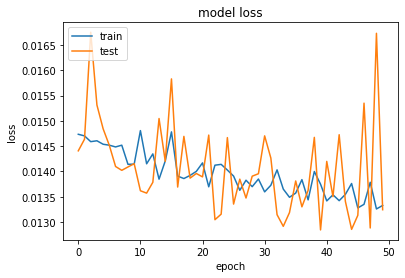

In [11]:
plt.plot(history.history['loss'][:100])
plt.plot(history.history['val_loss'][:100])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
import keras
model = keras.models.load_model('weights.best.hdf5')
y_pred = []
# for x_test in X_test:
#   y_pred.append(model.predict(X_test))
# y_pred

y_pred = model.predict(X_test, batch_size=8)

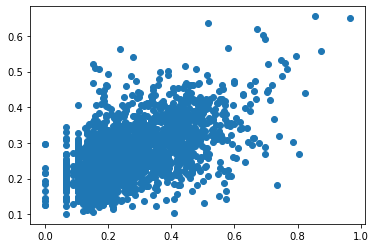

In [24]:
plt.scatter(y_test, y_pred)